### 测试模型在少样本条件下的准确率

In [1]:
import os
import sys
import math
from collections import OrderedDict, defaultdict
from typing import List, Tuple

import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm


from detect_api.clf_model import nearCenter, nearNeighbor, svm
from detect_api.feat_extractor import mobnet_openvino
from tools import AccuracyCounter, train_test_split_int

%load_ext autoreload
%autoreload 2

加载特征提取网络，加载特征分类器

In [2]:
weight_folder = '/Users/jiahua/Downloads/moving_det_cv/detect_api/weights'
feat_extractor = mobnet_openvino(
    xml_path=os.path.join(weight_folder, 'distil_mobv3_run1_best.xml'),
    bin_path=os.path.join(weight_folder, 'distil_mobv3_run1_best.bin')
)
cache = os.path.join(weight_folder, 'clf_model_0917_new_new_new.pkl')
model_dict = {
    'k-NN': nearNeighbor(cache_path=cache),
    'k-Centroid': nearCenter(cache_path=cache),
    # 'SVM': svm(cache_path=cache)
}

detection model initialization finished
the cache /Users/jiahua/Downloads/moving_det_cv/detect_api/weights/clf_model_0917_new_new_new.pkl has been loaded to classify model
the cache /Users/jiahua/Downloads/moving_det_cv/detect_api/weights/clf_model_0917_new_new_new.pkl has been loaded to classify model


/Users/jiahua/miniconda3/envs/nus/lib/python3.7/site-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


加载数据集图片

In [3]:
img_folder =  '/Users/jiahua/Downloads/moving_det_cv/tmp/wencui/sub_images'
img_paths = []
labels = []

folder_list = [name for name in os.listdir(img_folder) if name !='.DS_Store']
for name in folder_list:
    subfolder = os.path.join(img_folder, name)
    if not os.path.exists(subfolder):
        continue
    for img_name in os.listdir(subfolder):
        if img_name.endswith('.jpg'):
            img_paths.append(os.path.join(subfolder, img_name))
            labels.append(name)

print(img_paths[:2])


['/Users/jiahua/Downloads/moving_det_cv/tmp/wencui/sub_images/青椒炒蛋/IPS_2022-08-25.11.37.27.4280_1661878562.55157_0.jpg', '/Users/jiahua/Downloads/moving_det_cv/tmp/wencui/sub_images/青椒炒蛋/IPS_2022-08-03.11.43.24.8490_1661264747.7503629_2.jpg']


创建数据点对象，每个对象包括数据path、原图、特征等信息，便于跟踪。


In [4]:
class ImageData(object):
    def __init__(self, path):
        self.path = path
        self.img = None
        self.feat = None
        self.label = None
    
    def __repr__(self):
        s = f'path: {self.path}\nlabel: {self.label}'
        if self.feat is not None: s+= f'\nfeat length: {len(self.feat)}'
        if self.img: s+= f'\nimg size: {self.img.size}'
        return s

In [5]:
imgData_list = []
for path, label in zip(img_paths, labels):
    imgData = ImageData(path=path)
    imgData.label = label
    imgData_list.append(imgData)
    
imgData_list[:2]

[path: /Users/jiahua/Downloads/moving_det_cv/tmp/wencui/sub_images/青椒炒蛋/IPS_2022-08-25.11.37.27.4280_1661878562.55157_0.jpg
 label: 青椒炒蛋,
 path: /Users/jiahua/Downloads/moving_det_cv/tmp/wencui/sub_images/青椒炒蛋/IPS_2022-08-03.11.43.24.8490_1661264747.7503629_2.jpg
 label: 青椒炒蛋]

提取所有图片的特征

In [6]:
for imgData in tqdm(imgData_list):
    imgData.img = Image.open(imgData.path).convert("RGB")
    imgData.feat = feat_extractor.encode([imgData.img])[0]

100%|██████████| 5610/5610 [02:01<00:00, 46.13it/s]


In [7]:
imgData_list[0]

path: /Users/jiahua/Downloads/moving_det_cv/tmp/wencui/sub_images/青椒炒蛋/IPS_2022-08-25.11.37.27.4280_1661878562.55157_0.jpg
label: 青椒炒蛋
feat length: 960
img size: (555, 550)

选定模型，每次从数据集每个类中抽取一个样本做增量训练，并验证在测试集上的效果。第二次从预测错误的集合中采样。

验证集为训练集在总数据集上的补集，而非上一轮错误预测的合集。数据记录在表中，统计多个维度：每类中采样的数量size，使用的分类器模型model，召回类型recall type，召回得分score。

recall type 有micro，macro，和各个分类的名称


In [8]:
def increment_training(data: List[ImageData],
                       targets: List,
                       clf_model,
                       model_name: str,
                       df, # pandas.DataFrame, to record metrics
                       epoch_limit: int = 10,
                       ):
    """
    This function is to test classification model. In each iteration, one data per category
    is taken out from misclassified data of the previous epoch, and added to training set.
    The recall score will be recorded to dataframe.
    (Each time the function is called, a polyline is generated)
    """

    count = 0
    clf_model.clear_cache()
    wrong_data, wrong_targets = data, targets
    correct_data, correct_targets = [], []

    while count < epoch_limit and len(data) > 1:

        acc_counter = AccuracyCounter()
        train_x, valid_x, train_y, valid_y = train_test_split_int(
            wrong_data, wrong_targets, sample_per_class=1)

        # increment training
        clf_model.train_increment(data=[imgData.feat for imgData in train_x],
                                  label=train_y)

        # validate and calculate recall score
        valid_x += correct_data
        valid_y += correct_targets
        predictions = clf_model.predict([imgData.feat for imgData in valid_x])

        # print(len(valid_y))
        for target, pred in zip(valid_y, predictions):
            acc_counter[target] = (target == pred)

        # record metric
        for k in acc_counter.keys():
            df.loc[len(df)] = [count + 1, acc_counter.acc(k), str(k), model_name]
        for m in ['micro', 'macro']:
            df.loc[len(df)] = [count + 1, acc_counter.total_acc(method=m), m, model_name]

        # divide data by correct/wrong prediction
        wrong_data, wrong_targets = [], []
        correct_data, correct_targets = [], []
        wrong_preds = []

        for target, pred, imgData in zip(valid_y, predictions, valid_x):
            if target == pred:
                correct_data.append(imgData)
                correct_targets.append(target)
            else:
                wrong_data.append(imgData)
                wrong_targets.append(target)
                wrong_preds.append(pred)
        count += 1

    return wrong_data, wrong_targets, wrong_preds


In [9]:
df = pd.DataFrame(columns=['size','score','recall type','model'])

# model_name = 'k-Centroid'
# clf_model = model_dict[model_name]
# for name, clf_model in model_dict.items():
#     badcases = increment_training(all_feats, labels, clf_model, name, df, epoch_limit=30)
#     break

# name = 'k-Centroid'
# model_name = 'k'
# clf_model = model_dict[name]
for name, clf_model in model_dict.items():
    clf_model = model_dict[name]
    for i in tqdm(range(10)):
        badcases = increment_training(imgData_list, labels, clf_model, name, df, epoch_limit=10)


100%|██████████| 10/10 [00:53<00:00,  5.36s/it]


使用误差线折线图，将测试得分可视化

In [10]:
from matplotlib import font_manager
fm = font_manager.FontManager()
[f.name for f in fm.ttflist if 'CJK' in f.name]
# myfont = font_manager.FontProperties(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc')

Fontconfig warning: ignoring UTF-8: not a valid region tag


[]

In [12]:
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

In [13]:
# get the number of images of each class
labels_counter = {}
for imgData in imgData_list:
    if imgData.label in labels_counter:
        labels_counter[imgData.label] += 1
    else:
        labels_counter[imgData.label] = 1

/Users/jiahua/miniconda3/envs/nus/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


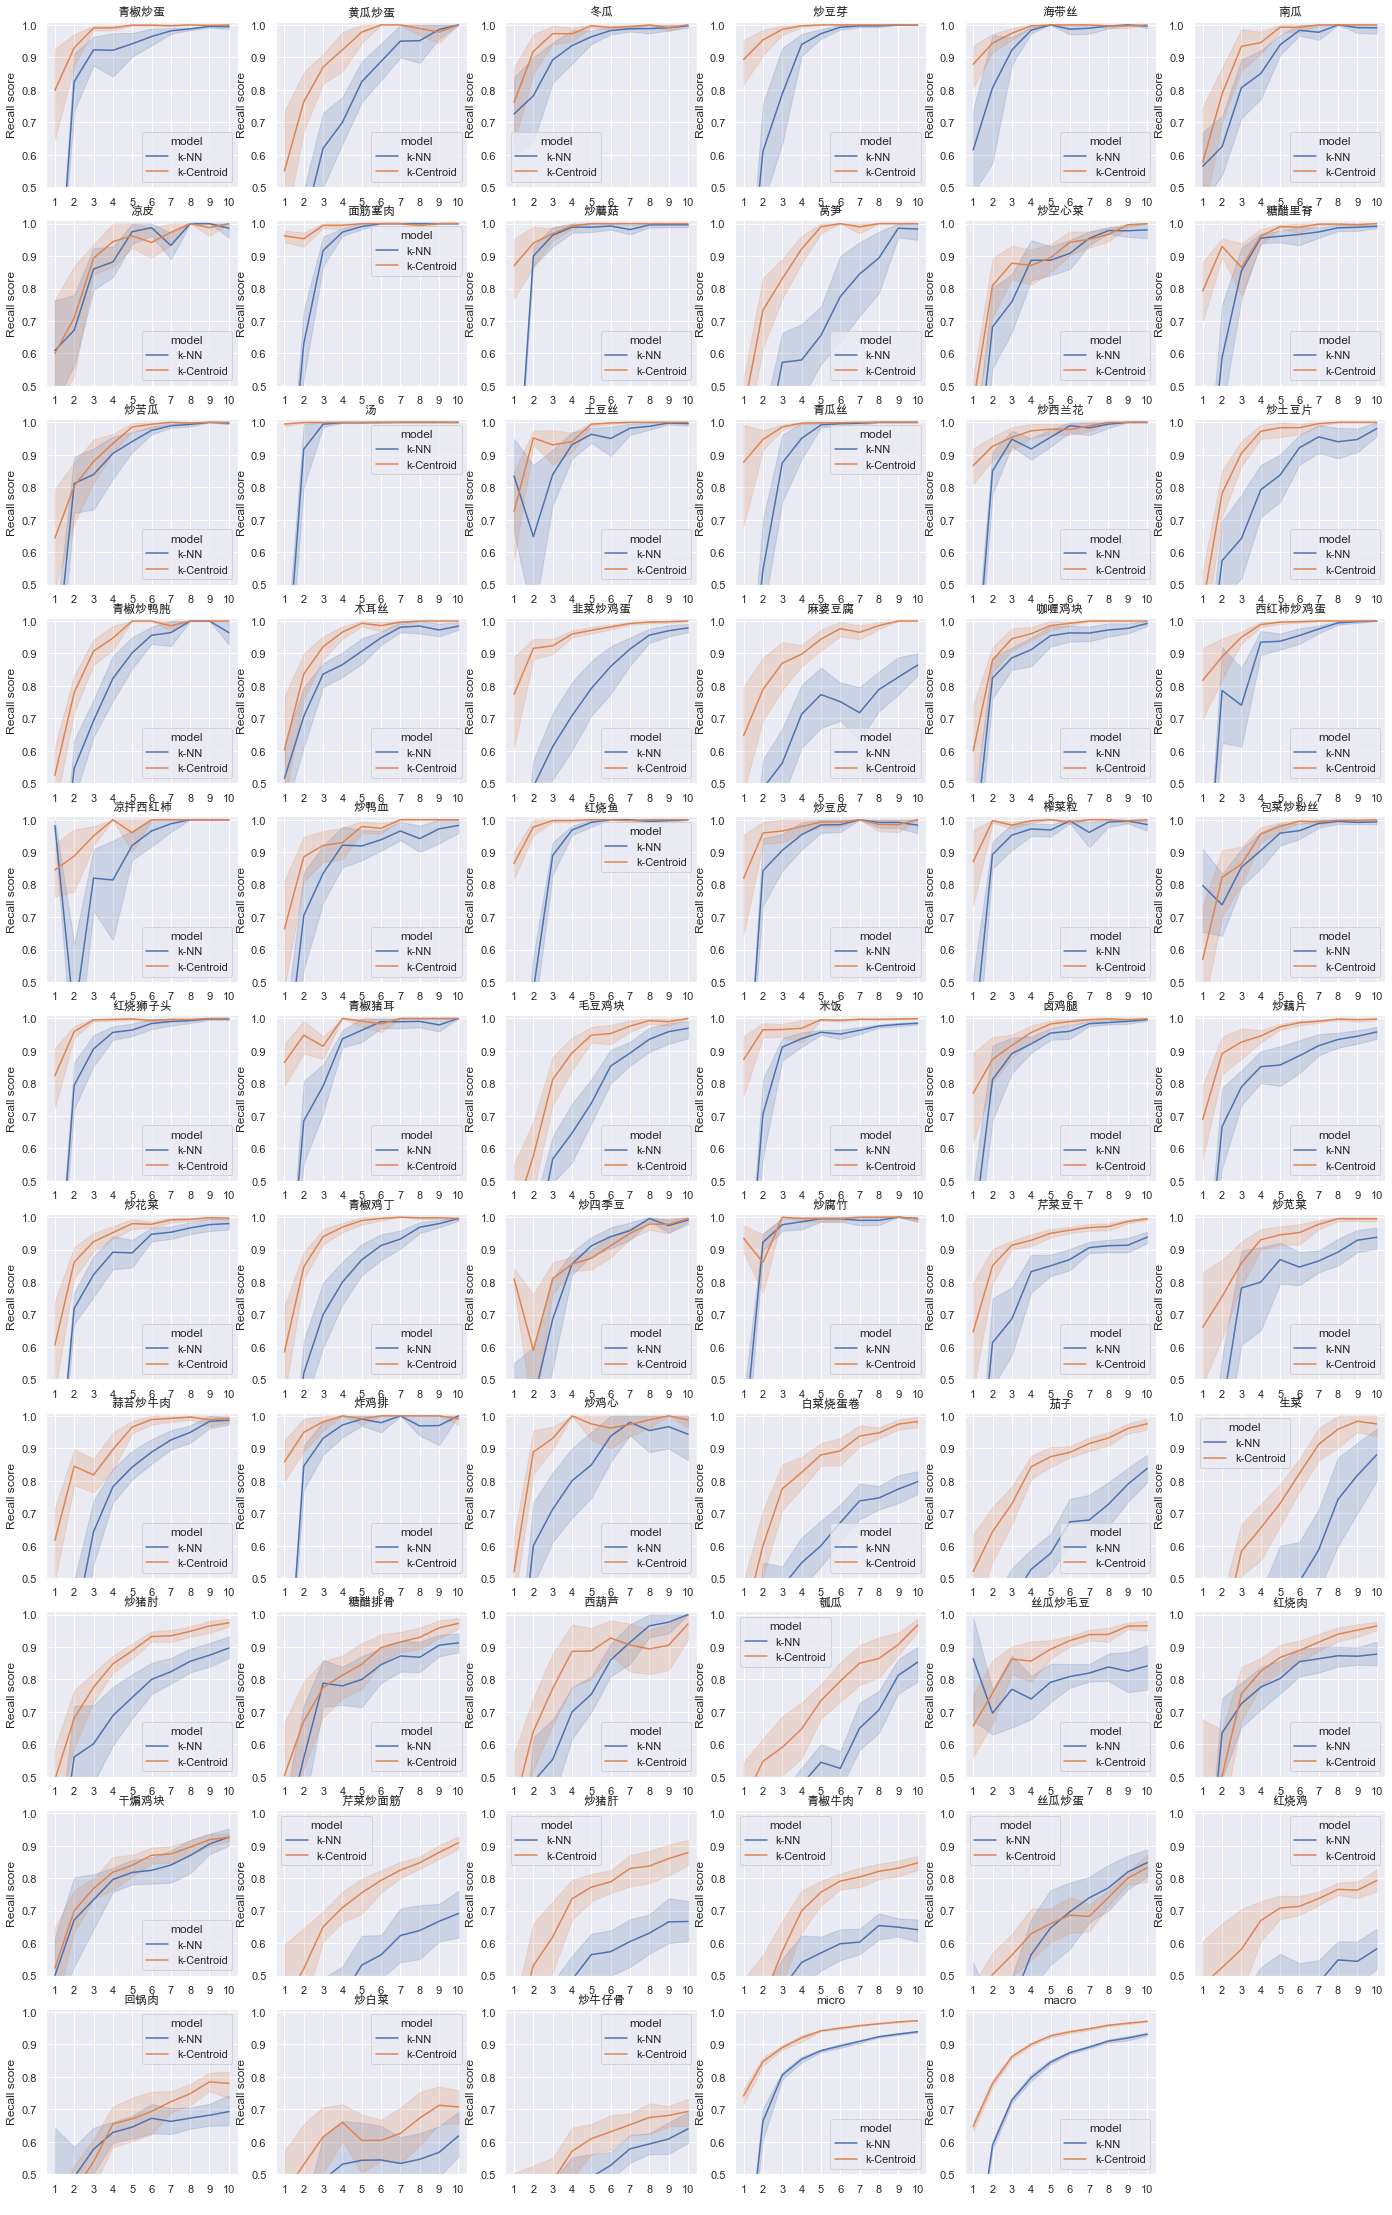

In [23]:
# Draw line plot with error bands of reall, against model/size/recall type
size_range = list(sorted(df['size'].unique()))
keys = df['recall type'].unique()[:-1] # not include 'micro' and 'marco'
keys = [k for k in keys if labels_counter.get(k,-1) > 10] # filter out classes with less than 10 samples
# sort keys by the accuracy
labels_avg_acc = {}
for k in keys:
    avg_acc = df[df['size']==10][df['model']=='k-Centroid'][df['recall type']==k]['score'].mean()
    labels_avg_acc[k] = avg_acc
keys = sorted(keys, key=lambda k: labels_avg_acc[k], reverse=True)
keys += ['micro', 'macro']

ncols = 6
nrows = math.ceil(len(keys)/ncols)
sns.set_theme(style='darkgrid')
sns.set(font='Arial Unicode MS')
# sns.set(font=myfont.get_name())

plt.figure(figsize=(ncols * 4, nrows * 3.6))
# plt.suptitle(f'model: {name}')
for i, k in enumerate(keys):
    sub_df = df[df['recall type'] == k]

    ax = plt.subplot(nrows, ncols, i + 1)  #, figsize=(15, 10))

    ax.set(xticks=size_range)

    # sns.lineplot(x="size", y="score", style="recall type", hue="model", data=df, ax=ax,  )
    sns.lineplot(x="size", y="score", hue='model', data=sub_df, ax=ax,)
    # ax.set_xlabel('sample number per category for training')
    ax.set_ylabel('Recall score')
    ax.set_xlabel(' ')
    ax.set_ylim([sub_df['score'].min() - 0.01, sub_df['score'].max() + 0.01])
    ax.set_ylim([0.5,1.01])
    ax.set_title(f'{k}')
# ax.set_title('Recall of different models with different train set size')
# plt.savefig('recall_model_size_mobnetv3_distill_collect2.png',dpi=300, tight_layout=True)
plt.savefig('recall_trainsize_each_class.png',dpi=200, tight_layout=True)



In [330]:
# the final recall score after incremental training on 10 samples
df[(df['recall type'] == 'micro') & (df['model'] == 'k-Centroid') & (df['size'] == 10)].mean()

size     10.000000
score     0.973139
dtype: float64

In [24]:
all_classes = df['recall type'].unique()[:-1]
print(all_classes, len(all_classes))

['青椒炒蛋' '炒包菜' '炒鸡心' '芹菜豆干' '黄瓜炒蛋' '炒四季豆' '回锅肉' '糖醋排骨' '冬瓜' '炒豆芽' '海带丝'
 '南瓜' '凉皮' '面筋塞肉' '炒蘑菇' '红烧带鱼' '青椒鸡丁' '莴笋' '炒空心菜' '糖醋里脊' '蒜苔腊肉' '丝瓜炒蛋'
 '炒苦瓜' '炒牛仔骨' '炒猪肘' '干锅鸡块' '芹菜炒面筋' '炒藕片' '白斩鸡' '汤' '干煸鸡块' '瓠瓜' '生菜' '土豆丝'
 '青瓜丝' '茄子' '白菜烧蛋卷' '炒西兰花' '炒土豆片' '青椒炒鸭肫' '西葫芦' '木耳丝' '韭菜炒鸡蛋' '炒苋菜'
 '蒜苔炒牛肉' '炒腐竹' '丝瓜炒毛豆' '烧咸肉' '米饭' '炒花菜' '麻婆豆腐' '卤鸡腿' '红烧萝卜' '咖喱鸡块'
 '西红柿炒鸡蛋' '凉拌西红柿' '青椒豆干' '青椒牛肉' '炒鸭血' '红烧鱼' '炒豆皮' '炒白菜' '炒猪肝' '榨菜粒'
 '包菜炒粉丝' '炸鸡排' '红烧肉' '红烧狮子头' '红烧鸡' '青椒猪耳' '毛豆鸡块' 'micro'] 72


In [25]:
len(keys)

65

展示所有的badcase，原标签和错误预测的标签

In [ ]:
wrong_imgData, _, wrong_preds = badcases
plt.figure(figsize=(15, len(wrong_preds)*2))
for i, (imgData, pred) in enumerate(zip(wrong_imgData, wrong_preds)):
    ax = plt.subplot(math.ceil(len(wrong_preds) / 3), 3, i + 1)
    ax.imshow(imgData.img)
    ax.grid(False)
    ax.set_title(f'{imgData.label}->{pred}')


将badcases单独保存为图片，文件名为正确->预测标签.jpg

In [15]:
wrong_imgData, _, wrong_preds = badcases
save_folder = '/Users/jiahua/Downloads/moving_det_cv/wrong_preds'
# plt.figure(figsize=(15, len(wrong_preds)*2))
for i, (imgData, pred) in enumerate(zip(wrong_imgData, wrong_preds)):
    title = f'{imgData.label}->{pred}'
    save_path = os.path.join(save_folder, f'{title}_{i}.jpg')
    imgData.img.save(save_path)

In [195]:
f'{imgData.label}->{pred}'

'咖喱牛肉->番茄牛肉'

统计错误预测的组合，出现的次数

In [250]:
wrong_pairs_counter = {}
labels_counter = {}
for i, (imgData, pred) in enumerate(zip(wrong_imgData, wrong_preds)):
    title = (imgData.label, pred)

    if title in wrong_pairs_counter:
        wrong_pairs_counter[title]+=1
    else:
        wrong_pairs_counter[title]=1
    
    if imgData.label in labels_counter:
        labels_counter[imgData.label]+=1
    else:
        labels_counter[imgData.label]=1
    
    if pred in labels_counter:
        labels_counter[pred]+=1
    else:
        labels_counter[pred]=1
# sorted(wrong_pairs_counter.items(), key=lambda x: x[1], reverse=True)

In [ ]:
clf_model = model_dict['k-NN']
train_x, valid_x, train_y, valid_y = train_test_split(imgData_list, labels, train_size=0.6, shuffle=True, stratify=labels)

acc_counter = AccuracyCounter()

train_x = [imgData.feat for imgData in train_x]
clf_model.train_all(data=train_x, label=train_y)

# validate and calculate recall score
predictions = clf_model.predict([imgData.feat for imgData in valid_x])

# print(len(valid_y))
for target, pred in zip(valid_y, predictions):
    acc_counter[target] = (target == pred)

print(acc_counter.acc('咖喱牛肉'))
print(acc_counter.total_acc(method='macro'))
print(acc_counter.total_acc(method='micro'))

画出被误检测出的类别的关联图，误检测越多，线越粗、节点越大

In [38]:
import networkx as nx

ok


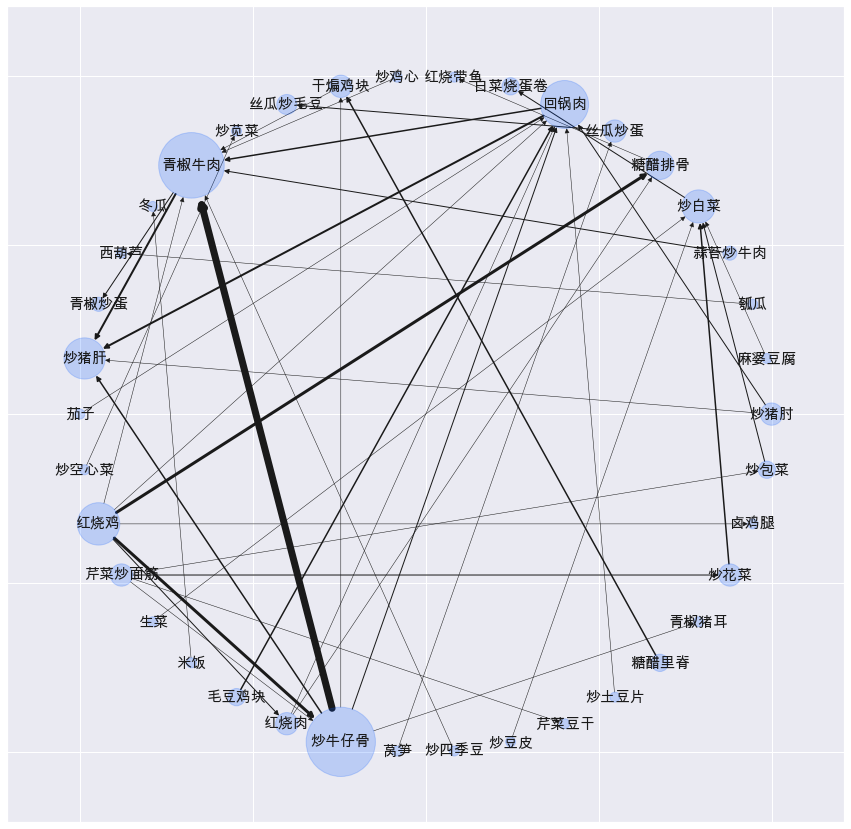

In [319]:
G = nx.Graph()
all_nodes = set()
all_edges = set()
edges_attrs = {}
nodes_attrs = {}
alphas = []
for i, (imgData, pred) in enumerate(zip(wrong_imgData, wrong_preds)):
    all_nodes.add(imgData.label)
    all_nodes.add(pred)
    # edge_str = f'{imgData.label}->{pred}'
    all_edges.add((imgData.label, pred))

for node in all_nodes:
    nodes_attrs[node] = {'num': labels_counter[node]}

for label, pred in all_edges:
    edges_attrs[(label, pred)] = {'weight':wrong_pairs_counter[(label, pred)]/2}


groups = sorted(nodes_attrs.keys(), key=lambda k: nodes_attrs[k]['num'], reverse=True)

G.add_nodes_from(all_nodes)
G.add_edges_from(all_edges)
nx.set_node_attributes(G, nodes_attrs)
nx.set_edge_attributes(G, edges_attrs)

nums = nx.get_node_attributes(G, 'num')
weights = nx.get_edge_attributes(G, 'weight')

plt.figure(figsize=(15,15))
pos = nx.shell_layout(G)
nx.draw_networkx(
    G,
    pos=pos,
    nodelist=list(nums.keys()),
    node_size=[n * 100 for n in nums.values()],
    node_color='#0055FF33',
    #  connectionstyle=f'arc3, rad = 0.5',
    edgelist=list(weights.keys()),
    width=list(weights.values()),
    arrows=True,
    font_family='Arial Unicode MS',
    font_size=15)
print('ok')